# 03/07/2025
# 03/10/2025

Show the plot for PWV vs Pressure/Height 


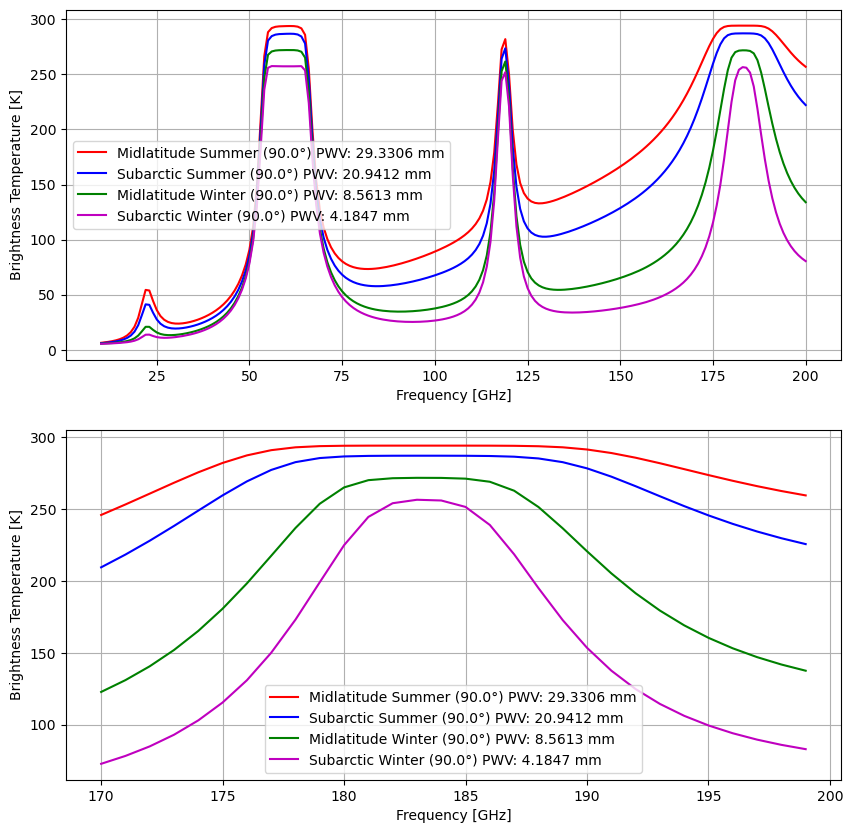

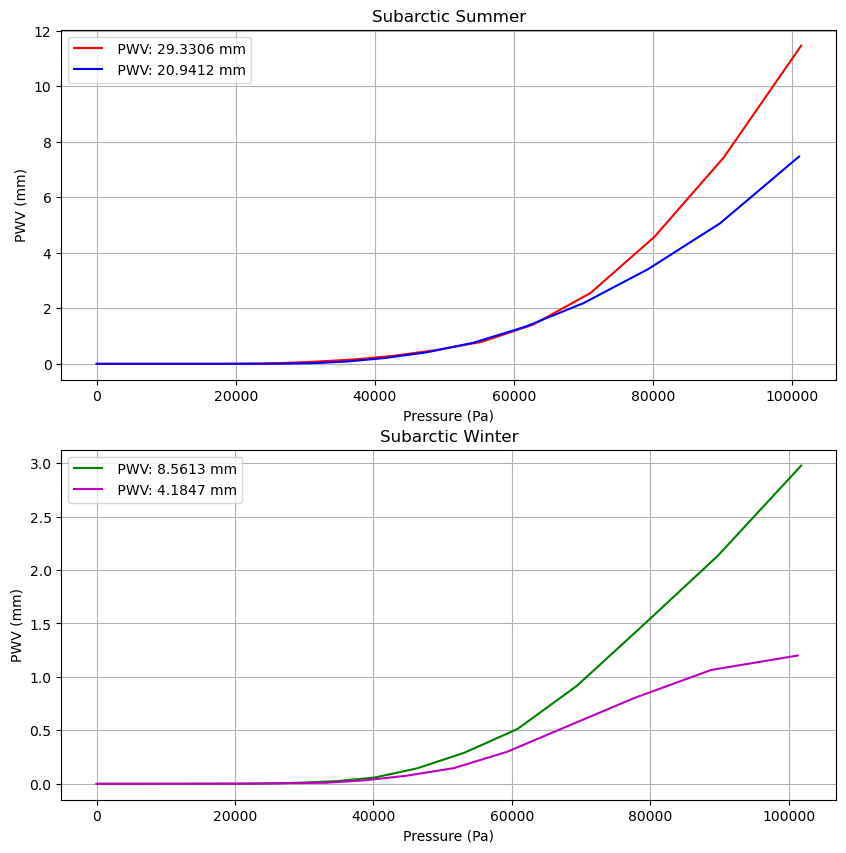

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pyrtlib.climatology import AtmosphericProfiles as atmp
from pyrtlib.utils import ppmv2gkg, mr2rh
from pyrtlib.tb_spectrum import TbCloudRTE

def PWV_array(rho,g,m_mix_kgkg,p_pa):
    """
    Calculate the precipitable water vapor from the mixing ratio.

    input:
        rho_w in kg/m^3
        g in m/s^2
        mass mixing ratio of water vapor in kg/kg
        pressure in Pa
        
    output:
        PWV(numpy.ndarray) in mm

    """
    PWV_arr = np.zeros(len(p_pa))
    PWV_sum = 0
    
    for i in range(len(p_pa) - 1):
        sum_m_P_rho = 0.5 * (m_mix_kgkg[i+1] + m_mix_kgkg[i]) * np.abs(p_pa[i+1] - p_pa[i])
        #Use Trapezoidal rule
        PWV_meter = sum_m_P_rho / (g*rho) # in m
        PWV_arr[i] = PWV_meter * 1000 # convert to mm
        PWV_sum += PWV_arr[i]

    return PWV_arr, PWV_sum

atms = [atmp.MIDLATITUDE_SUMMER, atmp.SUBARCTIC_SUMMER, atmp.MIDLATITUDE_WINTER, atmp.SUBARCTIC_WINTER]

g = 9.8 # m/s^2
colors = ['r', 'b', 'g', 'm']
cnt = 0
row = 0
col = 0
fig0, ax0 = plt.subplots(2, 1, figsize=(10, 10)) 
fig1, ax1 = plt.subplots(2, 1, figsize=(10, 10)) 

for atm in atms:
    z, p, _, t, md = atmp.gl_atm(atm)
    # z: Altitudes (km) 
    # p: Pressure (mbar)
    # t: Temperature (K)
    # md: Molecular densities (ppmv)
    md_H2O = md[:,atmp.H2O]

    p_pa = p*1e2 # convert to Pa

    m_mix_gkg = ppmv2gkg(md_H2O,atmp.H2O) # convert to g/kg
    m_mix_kgkg = m_mix_gkg * 1e-3 # convert to kg/kg (g/g?)

    rho_w_liq = 1000 #kg/m^3 in standard atmosphere room temperature

    PWV_arr, PWV_sum = PWV_array(rho_w_liq,g,m_mix_kgkg,p_pa)

    PWV_sum = np.round(PWV_sum, 4)

    rhum = mr2rh(p, t, m_mix_gkg)[0] / 100 # convert to relative humidity(%)
    frq_tot = np.arange(10, 201, 1)
    frq_foc = np.arange(170, 200, 1)
    ang = np.array([90.])

    for a in ang:
        rte_tot = TbCloudRTE(z, p, t, rhum, frq_tot, np.array([a]))
        rte_foc = TbCloudRTE(z, p, t, rhum, frq_foc, np.array([a]))

        rte_tot.init_absmdl('R16')
        rte_foc.init_absmdl('R16')
        
        rte_tot.satellite = False
        rte_foc.satellite = False

        df_tot = rte_tot.execute()
        df_foc = rte_foc.execute()
        
        df_tot = df_tot.set_index(frq_tot)
        df_foc = df_foc.set_index(frq_foc)

        ax0[0].plot(frq_tot, df_tot.tbtotal, label = atmp.atm_profiles()[atm] + ' (' + str(a) + '°)' + ' PWV: '
                    + str(PWV_sum) + ' mm', color=colors[cnt])
        ax0[1].plot(frq_foc, df_foc.tbtotal, label = atmp.atm_profiles()[atm] + ' (' + str(a) + '°)' + ' PWV: '
                    + str(PWV_sum) + ' mm', color=colors[cnt])
        ax0[0].set_ylabel('Brightness Temperature [K]')
        ax0[0].set_xlabel('Frequency [GHz]')
        ax0[0].legend()
        ax0[0].grid(True)

        ax0[1].set_ylabel('Brightness Temperature [K]')
        ax0[1].set_xlabel('Frequency [GHz]')
        ax0[1].legend()
        ax0[1].grid(True)

    #plot the PWV vs P in 4 subplot
    switch = atm
    if switch == atmp.MIDLATITUDE_SUMMER:
        row = 0
    elif switch == atmp.SUBARCTIC_SUMMER:
        row = 0
    elif switch == atmp.MIDLATITUDE_WINTER:
        row = 1
    elif switch == atmp.SUBARCTIC_WINTER:
        row = 1

    ax1[row].plot(p_pa, PWV_arr, label = ' PWV: ' + str(PWV_sum) + ' mm', color=colors[cnt])
    ax1[row].set_ylabel('PWV (mm)')
    ax1[row].set_xlabel('Pressure (Pa)')
    ax1[row].legend()
    ax1[row].set_title(atmp.atm_profiles()[atm])
    ax1[row].grid(True)

    cnt += 1

plt.show()

 


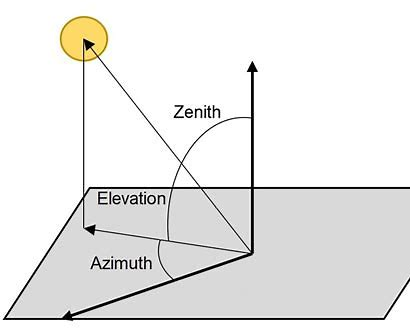

In [1]:
#convert the wavelegth to frequency
fre = 185e9 # in Hz
c = 3e8 # in m/s
wavelength = c / fre # in m
print('Wavelength: ', wavelength)


Wavelength:  0.0016216216216216215


In [3]:
lamb_upp = 4e-3
lambda_low = 300e-6
freq_upp = c / lamb_upp
freq_low = c / lambda_low
print('Upper frequency: (GHz)', freq_upp/1e9)
print('Lower frequency: (GHz)', freq_low/1e9)

Upper frequency: (GHz) 75.0
Lower frequency: (GHz) 1000.0000000000001
